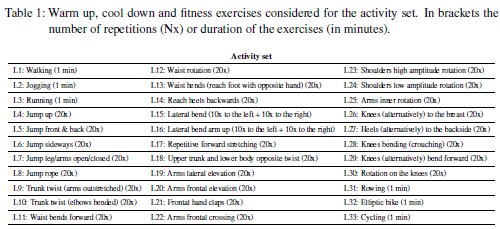

In [29]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.feature_selection import VarianceThreshold

data = pd.read_csv("subject4_ideal.log",delim_whitespace=True,header=None)

In [30]:
##Preprocessing

##Using dataset with ideal placement of sensors.
data = pd.read_csv("subject4_ideal.log",delim_whitespace=True,header=None)
#print(data)

##Check if dataframe contains NaN values, returns true if there are.
print("Does dataframe contain NaN values? {}".format(data.isnull().any().any()))

##Remove previous preprocessed file
if (os.path.exists('np.txt') == True):
    os.remove("np.txt")

##Feature selection with MEAN to reduce file size/rows. 
i = 0
rows_per_partition = 10
start = 0
end = rows_per_partition
remainder_rows = data.shape[0]%rows_per_partition
f = open("np.txt", "a")
while (i<data.shape[0]):
    
    np.savetxt(f, data[start:end].mean(axis=0).to_frame().T, fmt='%.6f', delimiter=' ')
    i+=rows_per_partition
    start += rows_per_partition
    end += rows_per_partition

##Add remainder rows
np.savetxt(f, data[data.shape[0] - remainder_rows :data.shape[0]].mean(axis=0).to_frame().T, fmt='%.6f', delimiter=' ')


##Dropping QUAT (Quaternion orientation estimates) and MAG (magnetic field measurements) columns as they are not relevant to the context of our project
delete_columns = []
count = 0;
i = 2;
while i < len(data.columns):
    count += 1
    if(count==6):
        #print(i)
        for j in range(8):
            delete_columns.append(i)
            i += 1
        count = 0
        i -=1
    i += 1

##Use preprocessed txt file
data = pd.read_csv("np.txt",delim_whitespace=True,header=None)

X = data.drop(delete_columns, axis = 1)        
Y = data[119].round().astype(int)

Does dataframe contain NaN values? False


In [31]:
from sklearn.metrics import f1_score

def train_model(model, X_train, y_train):
    clf = model
    clf.fit(X_train, y_train)
    return clf

def eval_model(clf, X_test, y_test, X_train, y_train):
    pred_clf = clf.predict(X_test)
    
    acc_test = clf.score(X_test, y_test)
    acc_train = clf.score(X_train, y_train)
    
    #print(X_test)
    #print(pred_clf)
    print("")
    print("Evluation for {}".format(clf))
    print("Train Accuracy: {}".format(acc_train))    
    print("Test Accuracy: {}".format(acc_test))
    print("F1: {}".format(f1_score(y_test, pred_clf, average="macro")))
    #print(classification_report(y_test, pred_clf))
    print(pd.crosstab(y_test, pred_clf, rownames=['True'], colnames=['Predicted'], margins=True))
    
##Standardize/Normalize features (Mean = 0, S.D = 1) 
def standardise_dataset(X_train, X_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    return X_train, X_test    

#Used stratified k fold so that each fold is a good representative of the whole dataset
from sklearn.model_selection import StratifiedKFold
strat_fold = StratifiedKFold(n_splits=2)

In [32]:
#Selecting best value param
# X_trainp, X_testp, y_trainp, y_testp = train_test_split(X, Y, test_size = 0.2)
X_trainp, X_testp, y_trainp, y_testp = X[:6000], X[6000:], Y[:6000], Y[6000:]
rfc = RandomForestClassifier(n_estimators=50) 

# param_grid = { 
#     'n_estimators': [200, 400, 600, 800],
# }
param_grid = { 
    'n_estimators': [100],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=ShuffleSplit(test_size=0.20, n_splits=1))
CV_rfc.fit(X_trainp, y_trainp)
print(CV_rfc.best_params_)
best_params = CV_rfc.best_params_
eval_model(CV_rfc, X_testp, y_testp, X_trainp, y_trainp)

# #Evaluation with stratified k fold
# for train_index, test_index in strat_fold.split(X, Y):
#     start_time = time.time()
    
#     X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], Y[train_index], Y[test_index]
#     X_train, X_test = standardise_dataset(X_train, X_test)
#     rf_clf = train_model(RandomForestClassifier(**best_params), X_train, y_train)
#     eval_model(rf_clf, X_test, y_test, X_train, y_train)
    
#     print("--- %s seconds ---" % (time.time() - start_time))
#     print("")
#     print("")

{'n_estimators': 100}

Evluation for GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                     

/Users/vanguyen/anaconda3/envs/ceg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vanguyen/anaconda3/envs/ceg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [33]:
#Selecting best K value param
knn = KNeighborsClassifier(n_neighbors = 1) 
n_neighbor_arr = list(range(2,3))
param_grid = { 
    'n_neighbors': n_neighbor_arr,
}

#CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 2)
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=ShuffleSplit(test_size=0.20, n_splits=1))
CV_knn.fit(X_trainp, y_trainp)
print(CV_knn.best_params_)
best_params = CV_knn.best_params_

# best_k = 1
# accuracy_list = []
# for i in range(1,10):   
#     knn_clf = train_model(KNeighborsClassifier(n_neighbors=i), X_trainp, y_trainp)
#     pred_clf = knn_clf.predict(X_testp)
#     acc_test = knn_clf.score(X_testp, y_testp)
#     accuracy_list.append(acc_test)
# #     print(i)
# #     print(acc_test) 
# best_k = accuracy_list.index(max(accuracy_list)) + 1


#Evaluation with stratified k fold
for train_index, test_index in strat_fold.split(X, Y):
    start_time = time.time()
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], Y[train_index], Y[test_index]
    X_train, X_test = standardise_dataset(X_train, X_test)
    knn_clf = train_model(KNeighborsClassifier(**best_params), X_train, y_train)
    eval_model(knn_clf, X_test, y_test, X_train, y_train)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    print("")
    print("")


{'n_neighbors': 2}

Evluation for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
Train Accuracy: 0.9878345498783455
Test Accuracy: 0.9058380414312618
F1: 0.8123999548464764
Predicted     0    1    2    3   4   5   6   7   8   9  ...  23  24  25  26  \
True                                                    ...                   
0          1785   45   21   37   5   0  20   7   5   2  ...   0   0   1   0   
1             9  127    0    0   0   0   0   0   0   0  ...   0   0   0   0   
2            10   11  124    0   0   0   0   0   0   0  ...   0   0   0   0   
3             0    0   11  110   0   0   0   0   0   0  ...   0   0   0   0   
4             0    0    0    0  29   0   0   0   0   0  ...   0   0   0   0   
5             0    0    0    0  12  37   0   0   0   0  ...   0   0   0   0   
6             1    0    0    0  10   0  39   0   0   0 

/Users/vanguyen/anaconda3/envs/ceg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Evluation for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
Train Accuracy: 0.9852031207963411
Test Accuracy: 0.8896999188969992
F1: 0.8342038003834595
Predicted     0    1    2    3   4   5   6   7   8   9  ...  23  24  25  26  \
True                                                    ...                   
0          1750   14    0    0   0   0   0   0   0   0  ...   0   0   0   0   
1            46   89    0    0   0   0   0   0   0   0  ...   0   0   0   0   
2            12    0  132    0   0   0   0   0   0   0  ...   0   0   0   0   
3            15    0    1  103   0   0   0   0   0   0  ...   0   0   0   0   
4             1    0    0    0  26   0   0   0   0   0  ...   0   0   0   0   
5             3    0    0    0  11  34   0   0   0   0  ...   0   0   0   0   
6             4    0    0    0   2   0  42   0   0   0  ...   0   0   0   

Random forest classifier performed better. Its an ensemble method while knn is not, the ensemble method achieves a reduced variance by combining the decision trees.

Model with low variance pays lesser of attention to training data and tends to generalize more on the data which it hasn’t seen before. As a result, such models has lower error rates on test. This yields an overall better method.

Random forest use less mem

Knn does not do well with datasets with lots of features.